In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

!pip install rouge/requirements.txt
!pip install rouge-score

     |████████████████████████████████| 3.1 MB 13.5 MB/s 
     |████████████████████████████████| 3.3 MB 42.5 MB/s 
     |████████████████████████████████| 895 kB 44.2 MB/s 
     |████████████████████████████████| 61 kB 511 kB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 12.3 MB/s 
     |████████████████████████████████| 243 kB 50.7 MB/s 
     |████████████████████████████████| 1.1 MB 36.6 MB/s 
     |████████████████████████████████| 132 kB 52.7 MB/s 
     |████████████████████████████████| 271 kB 46.2 MB/s 
     |████████████████████████████████| 192 kB 51.0 MB/s 
     |████████████████████████████████| 160 kB 47.3 MB/s 
     |████████████████████████████████| 123 kB 11.2 MB/s 
     |████████████████████████████████| 131 kB 45.2 MB/s 
     |████████████████████████████████| 7

In [3]:
import os
import time
# from google.colab import drive

import json
import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, \
GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer, EncoderDecoderModel
from transformers import AdamW, get_linear_schedule_with_warmup

from datasets import load_dataset

from helper import format_time, rouge
from data import GPT2Dataset, preprocessing, split_data
from plots import loss_curves

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="/content/drive/My Drive/Colab Notebooks" )

Downloading:   0%|          | 0.00/3.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Using custom data configuration en-7330ead6fca24743


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-7330ead6fca24743/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
cd_df = covid_dialog['train'].to_pandas()
print(len(cd_df))
cd_df.head()

572


,dialogue_id,dialogue_url,dialogue_turns
0,1,https://www.icliniq.com/qa/covid-19/i-have-cou...,"{'speaker': [0, 1, 0, 1], 'utterance': ['I hav..."
1,2,https://www.icliniq.com/qa/covid-19/i-have-a-l...,"{'speaker': [0, 1, 0, 1, 0, 1, 0, 1], 'utteran..."
2,3,https://www.icliniq.com/qa/coronavirus/can-cor...,"{'speaker': [0, 1], 'utterance': ['Can Coronav..."
3,4,https://www.icliniq.com/qa/covid-19/i-have-chi...,"{'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ..."
4,5,https://www.healthcaremagic.com/premiumquestio...,"{'speaker': [0, 1], 'utterance': ['Does COVID-..."


In [6]:
qa_df = preprocessing(cd_df)
text = qa_df.text.copy()

qa_df.head()

/content/data.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_fields = np.transpose(np.array(all_fields).reshape((4, -1)))


,id,encoder,decoder,text
0,0,[I have cough with no travel history. Is this ...,"[Hello, I understand your concern. I just have...",[I have cough with no travel history. Is this ...
1,0,[I have cough with no travel history. Is this ...,"[Hi, I would recommend you take n-acetylcystei...",[I have cough with no travel history. Is this ...
2,1,[I have a little fever with no history of fore...,"[Hello, I can understand your concern.In my op...",[I have a little fever with no history of fore...
3,1,[I have a little fever with no history of fore...,"[Hi, yes, upload in this query only. I will se...",[I have a little fever with no history of fore...
4,1,[I have a little fever with no history of fore...,"[Hi, I can understand your concern. I have gon...",[I have a little fever with no history of fore...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


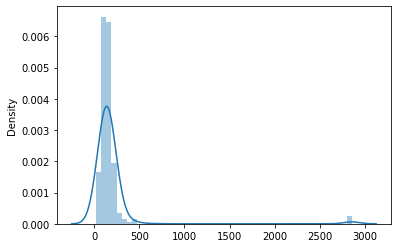

In [7]:
doc_lengths = []

for bio in text:
  
    # get rough token count distribution
    tokens = nltk.word_tokenize(bio[0])

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [8]:
torch.cuda.empty_cache()

In [9]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs

encoder_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# encoder_tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
GPT2TokenizerFast.build_inputs_with_special_tokens = build_inputs_with_special_tokens
decoder_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
# decoder_tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")

model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "gpt2")
# model = EncoderDecoderModel.from_encoder_decoder_pretrained("microsoft/DialoGPT-small", "microsoft/DialoGPT-small")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.8.ln_cross_attn.weight', 'h.9.crossattention.c_proj.bias', 'h.9.crossattention.bias', 'h.11.crossattention.q_attn.weight', 'h.5.crossattention.masked_bias', 'h.3.crossattention.c_attn.weight', 'h.6.crossattention.q_attn.weight', 'h.8.crossattention.masked_bias', 'h.2.crossattention.c_proj.bias', 'h.5.crossattention.c_proj.weight', 'h.9.crossattention.q_attn.weight', 'h.11.crossattention.c_proj.weight', 'h.8.crossattention.q_attn.weight', 'h.8.crossattention.c_attn.weight', 'h.6.crossattention.masked_bias', 'h.7.crossattention.c_proj.bias', 'h.11.crossattention.masked_bias', 'h.1.crossattention.bias', 'h.5.crossattention.c_proj.bias', 'h.10.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.weight', 'h.0.crossattention.c_proj.bias', 'h.11.crossattention.c_attn.weight', 'h.1.ln_cross_attn.weight', 'h.2.crossattention.masked_bias', 'h.11.crossattention.bias', 'h.2.c

In [10]:
encoder_tokenizer.bos_token = encoder_tokenizer.cls_token
encoder_tokenizer.eos_token = encoder_tokenizer.sep_token
# decoder_tokenizer.pad_token = decoder_tokenizer.unk_token

decoder_tokenizer.pad_token = decoder_tokenizer.eos_token
encoder_tokenizer.pad_token = encoder_tokenizer.eos_token
# encoder_tokenizer.bos_token = encoder_tokenizer.eos_token

model.config.decoder_start_token_id = decoder_tokenizer.bos_token_id
model.config.eos_token_id = decoder_tokenizer.eos_token_id
model.config.max_length = 142
model.config.min_length = 56
model.config.no_repeat_ngram_size = 3
model.length_penalty = 2.0

In [11]:
batch_size = 2

unique_vals = qa_df.id[len(qa_df)-1]

# Split into training and validation sets
train_size = int(0.8 * unique_vals)
val_size = int(0.1 * unique_vals)
test_size = unique_vals - train_size - val_size

train_split, val_split, test_split = split_data(qa_df, [train_size, val_size, test_size])

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)
test_split.reset_index(drop=True, inplace=True)

print(train_split.head())

print("length of dataset: " + str(unique_vals))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

train_dataset = GPT2Dataset(train_split, encoder_tokenizer, decoder_tokenizer, max_length=512, decoder_only=True)
val_dataset = GPT2Dataset(val_split, encoder_tokenizer, decoder_tokenizer, max_length=512, decoder_only=True)
test_dataset = GPT2Dataset(test_split, encoder_tokenizer, decoder_tokenizer, max_length=512, decoder_only=True)

    id  ...                                               text
0  322  ...  [Hello, I would like assistance with managing ...
1  135  ...  [What is the recovery time for pneumonia?Hi, m...
2  434  ...  [Where can I get tested for Corona if I am in ...
3    1  ...  [I have a little fever with no history of fore...
4   27  ...  [I travelled to Austria on 25 Jan 2020 and ret...

[5 rows x 4 columns]
length of dataset: 571
  456 training samples
   57 validation samples
   58 test samples


In [12]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [13]:
useCuda = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cuda


In [14]:
# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.encoder.resize_token_embeddings(len(encoder_tokenizer))
model.decoder.resize_token_embeddings(len(decoder_tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [15]:
# some parameters I cooked up that work reasonably well
epochs = 5
learning_rate = 5e-5 #5e-4
warmup_steps = 2000 #1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [16]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [17]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [18]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_decoder_input_ids = batch[1].to(device)
        b_labels = batch[1].to(device)
        b_masks = batch[3].to(device)
        b_decoder_masks = batch[4].to(device)
        model.zero_grad()        

        # print(b_input_ids.shape)
        # print(b_masks.shape)
        # print(b_decoder_input_ids.shape)

        outputs = model(input_ids=b_input_ids,
                          labels=b_labels, 
                          attention_mask=b_masks,
                          decoder_input_ids=b_decoder_input_ids,
                          decoder_attention_mask=b_decoder_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            # print(b_input_ids)
            # print(b_decoder_input_ids)

            sample_outputs = model.generate(
                                    input_ids=b_input_ids,
                                    # bos_token_id=encoder_tokenizer.bos_token,
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, decoder_tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        #print(b_input_ids.shape)
        b_input_ids = batch[0].to(device)
        b_decoder_input_ids = batch[1].to(device)
        b_labels = batch[1].to(device)
        b_masks = batch[3].to(device)
        b_decoder_masks = batch[4].to(device)
        
        with torch.no_grad():        

            #print(b_input_ids.shape)
            outputs  = model(input_ids=b_input_ids,
                          labels=b_labels, 
                          attention_mask=b_masks,
                          decoder_input_ids=b_decoder_input_ids,
                          decoder_attention_mask=b_decoder_masks,
                          token_type_ids=None
                        )
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...


/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:490: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    228. Loss: 0.975335419178009.   Elapsed: 0:02:07.
0: 
The New York Times released its best new reporting in the past 12 years Friday, with a major story about what happened inside the offices of the World Bank. It may be the newsiest and best-read I've had during this past year and a half. I wrote at least a hundred times of everything. It includes three columns that stand out:

– First, the first is a remarkable account of the state of the world's financial system. This was a post-2008 that was only half full in a decade, a record that will make it back to full soon in the next several years. (It is in fact over)

The second is a good one. The story is based in the aftermath of the global financial meltdown in 2010, when financial officials under the watch of the International Monetary Fund, under the umbrella of the European Union, intervened to rescue the economy. In the aftermath, the world was in turmoil. The New York team got a big ask:
1: Greetings,

For tho

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    228. Loss: 0.17604130506515503.   Elapsed: 0:04:26.
0: 
The second-highest rated college for students with a B or above

*Note: All grades are subject to the grade system test

1

SUNDAY, 10 P.M. (EST)

This morning's lecture was one of the most difficult of the day

4

WEDNESDAY, 9 P.m. (AP)

1: ...

..
 (1) In addition to those acts referred to in subparagraph (2), the Attorney shall consider the other acts with respect to which the the the is of the of the the of that the the if a the the a a a as the the as the as as as by virtue of this act as as when the the are of the that the as by the shall take the the taking the the take the taking it shall take it shall took it shall taken it shalltake it shall Take it shallTake it shallTaking it shallBe taken the being taken the having that the said the the said said said the said as as the said described by clause 3 thereof the said taken the as and described by that clause in clauses 4 to 12 thereof thesaid said said

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    228. Loss: 0.033520497381687164.   Elapsed: 0:02:10.
0: It's a great day to be a parent in the UK, we've had a lovely month to be in the world. This day of school time is the day of our first day in the country. We'll be taking care of our little ones, we'll be giving them good toys and treats. For us this is the very happiest day in Britain.

There will be a feast of the day with some of our favourite foods, some of the favourites we've always been giving them and some of their favourite treats, and a feast with some lovely places and places to be with our little children. It is a great time to be as a parent.
1: A few people I know said, "Don't tell people to ask people to say. "A few were said, 'Don't say.' " A few were also also also often often often many many many few many many numerous many many countless many many often many few few many few several many many others many many lots many many lot lots many much many many long long long much many lots lots lot

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    228. Loss: 0.03315627947449684.   Elapsed: 0:04:29.
0: A New York State Court of Appeals has declared that its use of a private key card card to enter a state's public open open open has been illegal because the private key is public open has to be signed by a person with a valid valid valid private private private Private Private Private

A New Jersey court of appeals has declared the use of private key cards to enter an an ananananansanansansansanananasansansanasanasanasansanasansanesanasanasanaanasanasananasanasanesanasansananasanansanasanananaanasansanosananasanaansanasanosanasanasasasasanasanasanosanosanosanasananaansansanesansanosanasanosanesanasanosansanosanosansanasanaananasanosannansanasannansansantsansansanosansansancananasannananasancansansannansanancansanasancanasancanancanannansannanasansannanancannans
1: Mitt Romney (R-MI) on Monday insisted that the U.S. had not been able to contain itself, even though it had been able not in this period.

The Republ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    228. Loss: 0.029073944315314293.   Elapsed: 0:02:09.
0: You can try it yourself.

And you can do it yourself and you and you.
................



....,,,,,,,,.. : : :::: : :..

.
1: The following is a list of the most recent items that are to be to be sold. If you wish to sell your item please please pleasepleasepleasepleasePleasePleasePlease PleasePleasePleasepleasePleasepleaseplease PleasePleaseplease Please PleasePlease Please Please Please pleasePleasePleaseSeePleasePleaseStayPleasePleaseHerePleasePleaseComePleasePleaseCheckPleasePleaseDoPleasePleaseJustPleasePleaseHelpPleasePleaseWePleasePleaseNoNoNoTheTheTheIII I I I i I I

Advertisements


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    228. Loss: 0.006761016324162483.   Elapsed: 0:04:23.
0: J.R. Tolkien, A.J. W. Willem, J.R-R.R

[1949]

A.J._J._._._.._._.(....(..( and

Wulf) the spirit of the sun and the star,

that is, the spirit in the spirit on the the the

the the the spirit, the the; the the its its its it it it

it it it its its Its Its Its It It It Its Its its its

its its itsItsItsItsItItItItsItsitsitsitsititititsitsitizeditizeditized

ITSITSITSITITITITSITSitsitsITSITSISSISSISSissississussississ

Its its itsitsitsitizitizitizitismitismitismiticiticiticitit itititItItitit

It it it. it.it.it; it it;
1: Golugus bovineus and Golugus sativaus were isolated isolated isolated isolation isolated isolated isolate isolated isolated isol isolated isolatedisolisolisolíííiiiííóóóíóííáííéííánííásííísííérííicííizííicoííesíínieííannííñáááíááóíáéíáóóÁóóáíóáóáááníánóáánóáníáásíáánááäááàááásááétááéááacááachááésááathíáÁáá�óóánáóánóóäáó�óá�áá Áá�ánáánánáééáéöááāááadááabááak

  Average training loss: 0.02
  T

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    228. Loss: 0.010484619997441769.   Elapsed: 0:02:09.
0: A more practical approach is to use a system called " " " / / //// / / : / /... / /:/:/:/.:.:.:!:.:.:*:*:*:****.*.*.*:*:*)*)*)/)*)*)())())())*)())*)*))((((:(:(:(:,:,:,:':':'::::':':":":":':':(:(:::-:-:-:(:(:-:-.:.:...................……....…)…)…)...)…)…)*)*)*****((::(:(::(:(.(:(:(():():():())())()()()())())((":":":::(.(.(:(.((:(:-.-:-:-:":":(:(.:.:.?.:.:.,.,.,,,.,.,,,,)…)…)?)…)…)())())

You can read some of the good advice here if you
1: In May, the Kia's will'',',',,,, and,,'''', ', ',,,,,,,,......::::-:-:-....,, ', ',', ', ', '. '. '. ', ','','',, ( ( ('' : : ::::':':'-'-'-'-.-'-'-,-'-'++++.+.+.+,+,+,,,.,.,.,,,.,.,%,.,.,,..,.,,'.,.,,,::!:':':::,:,:,::,:::(::(:(:(:,:,:(:(:::[.:.:.:.,.,...,.,',.,.,,, or,, either, either or or or either or either either either,, ],, ), ], ), ), ),, ), ), ) ), ), ],), ( ( ())), ( ()), ( ())))) (


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    228. Loss: 0.013586869463324547.   Elapsed: 0:04:28.
0: The Federal Trade Commission rules are designed to provide information on how these regulations are being implemented under their Title. This is the the the that that that is that that this this this that this these these these this this these this these such these these such such these such this this such this such these this such such this these like this this like this like like like thislike like like similar like likelikelikelike likelike like liked like like liked liked like liked likes liked liked liked likes likes liked like likes like like liking like like Like like like likes liked likes like likes likes likes like liked liking likes likes liking likes liked liking liking like likes liking like liking liking liking liked liking like liked mostly mostly mostly usually mostly mostly generally mostly mostly mainly usually mostly usually usually mostly always mostly always usually usually usually always 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    228. Loss: 0.009018796496093273.   Elapsed: 0:02:09.
0: If you think you've won the war (or just just just plain plain plain pretty pretty pretty plain pretty quite quite quite really really really't't't's's's the the the that the the,,,,.,.,.-.-.-.-,-,-,,, to, to, to,,, to : : :,,,,.,.,.,,,,,......::: : :

If you make a good thing ( ( ( (( ( ((((((((((((((((-(-(--.-.---.---.--.-.-(-(-(((.(.(.(..(.(.*.(.(.�.(.(.,.,.................................... 7 8 8 8 9 9 9 10 10 10 11 11 11 10 11 10 10 9 9 1 1 1

The thing is is is are are are is
1: The following questions or comments might help you answer this question:

1) Is the weather in the sky sky sky?

2) Is it it it that that that a a a that that such such such or or or and and andandandand andand and and & & & and and,,, and and. and and thanandandorandandnotnotnotNOTNOTNOT NOT NOT NOTNOTNOTNotNotNotStillStillStill Still Still Still But But But but but but...)))--- - - - 5 12 14 14 14 9 9 9 8 8 8


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    228. Loss: 0.009573482908308506.   Elapsed: 0:04:29.
0: The only thing that could have prevented it was the death of one of the the the, the the it the the he the the l the the a a a b b b B B B b b ba ba ba Ba Ba Ba ba ba d d d db db dbdbdbdb db db DB DB DBDBDBDBdbdbdcdcdc dc dc dcdcdcdbdbdadada da da da Da Da Da da dadadadfdfdfdididininininnnnananaanaanaanaanasanasanasanaanasanaanaastastastacastastustustuststststshshshashashashshshShShShSHSHSHShShshshSHShshShshashshashShShSlSlSlShSlShShslSlSlStstststestesteststestststrstststationststationstationstationstststatststatstatstatstststatusststat ststst St
1: R-R-D-E-GGG-G G G G g g g G g G GGG GG G ggggggggggrgggggghghghggghgghghggggoggggggiggiggiggaggaggaggagagagaggaggargargargagagargargaggaggacacacaaaasasasassassassasassasasaaananananaanaanaannanaannannannancancancacacaccaccaccacaccacacicicicacacancancacsacsacsacacastastastacacapacacacaacacracacaciacacacacsacacsacscascascasacsacsaccacciccicciccicicicsicsicsistsicsics

In [19]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.08,0.06,0:05:12,0:00:12
2,0.05,0.02,0:05:14,0:00:12
3,0.02,0.02,0:05:09,0:00:12
4,0.01,0.01,0:05:14,0:00:12
5,0.01,0.01,0:05:14,0:00:12


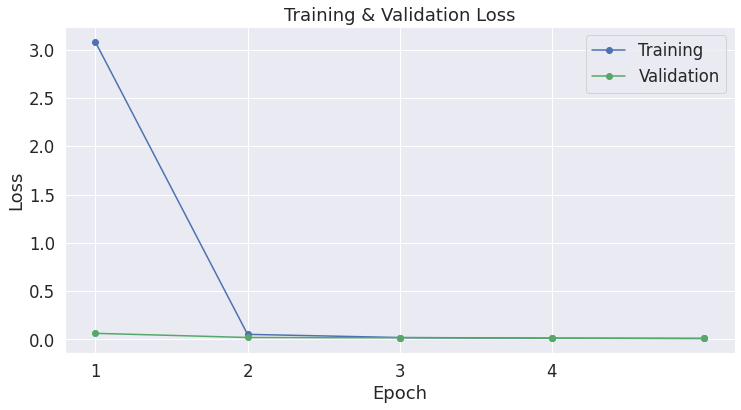

In [20]:
loss_curves(df_stats)

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 443 different named parameters.

==== Embedding Layer ====

encoder.embeddings.word_embeddings.weight               (30522, 768)
encoder.embeddings.position_embeddings.weight             (512, 768)

==== First Transformer ====

encoder.embeddings.token_type_embeddings.weight             (2, 768)
encoder.embeddings.LayerNorm.weight                           (768,)
encoder.embeddings.LayerNorm.bias                             (768,)
encoder.encoder.layer.0.attention.self.query.weight       (768, 768)
encoder.encoder.layer.0.attention.self.query.bias             (768,)
encoder.encoder.layer.0.attention.self.key.weight         (768, 768)
encoder.encoder.layer.0.attention.self.key.bias               (768,)
encoder.encoder.layer.0.attention.self.value.weight       (768, 768)
encoder.encoder.layer.0.attention.self.value.bias             (768,)
encoder.encoder.layer.0.attention.output.dense.weight     (768, 768)
encoder.encoder.layer.0.attention.output.dense.bias           

In [22]:
model = model.to('cpu')
rougeL = []
rougeLsum = []

for i, encoder_input in enumerate(test_dataset.input_ids):
    encoder_input = encoder_input[encoder_input != 50256]
    encoder_input = torch.reshape(encoder_input, (1, -1))

    predicted = model.generate(encoder_input, max_length=200)
    
    decoded_input = encoder_tokenizer.decode(encoder_input[0], skip_special_tokens=True)
    decoded_prediction = decoder_tokenizer.decode(predicted[0], skip_special_tokens=True)
    decoded_ground = decoder_tokenizer.decode(test_dataset.decoder_ids[i], skip_special_tokens=True)
    
    print("input: ")
    print(decoded_input)
    print("prediction: ")
    print(decoded_prediction)
    print("ground: ")
    print(decoded_ground)
    rouge_dict = rouge(decoded_prediction, decoded_ground)
    rougeL.append(rouge_dict["rougeL"])
    rougeLsum.append(rouge_dict["rougeLsum"])

avg_rougeL = sum(rougeL)/len(rougeL)
avg_rougeLsum = sum(rougeLsum)/len(rougeLsum)

print("RougeL: " + str(avg_rougeL))
print("RougeLsum: " + str(avg_rougeLsum))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
can i see a dr online for all my medication refills so i don't have to go into a dr office? i need medicine refillscan i see a dr online for all my medication refills so i don't have to go into a dr office? i need medicine refills
prediction: 
In the early days of the the the a a a an an an a a as as as a a A A A a aa a a the the that that that the the of the of of of the a of of a of a a of an an one one one 1 1 1111 1 1 0 0 0 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8 9 9 9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23 24 24 24 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31 30 31 30 30 29 29 59 59 59 60 60 60 59 59 58 59 59 57 57 57 59 59 5 5 4 4 3 3 2 2 1 1


ground: 
Maybe not all meds. COVID-19 pandemic at this time, so one's doctor may want to consult by video instead of requiring an in-person visit. Some medications are refillable by video, others are not. In this pandemic,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
how to treat pneumonia? i have been sick for going on four weeks now. it keeps changing each week from a stuff nose wear i cant breathe at all to my throat hurting and my chest hurting when i breathe or talk. im constantly falling asleep and keep having a fever on and off all the time. i went to the urgent care a week ago n they said i had the beginning of pneumonia. he only gave me a zpack and some cough medicine. the thing is i feel worse not better at all.... what should i do?
prediction: 
In the early days of the new millennium, the world was a place of chaos. The world was an place of chaotic. The World was an a a a an an an a an a as as as As As As AS AS ASASASASISISIS IS IS ISISISIsISISisisisisesisesisesizesisesisesisersisesisesistsisesisesitesitesitesisesisesitsisesisesisisISISISSISSISSISISSIISISISCISISISMISISISAISISISTISISICISISIISISIZISISITISISIAISISIFISISIBISISIGISISILISISIEISISIVISISIDISISIKISISIDESISISIESISISINKISISIJISISITTISISINISISIANISISIASISISUSISISITSISISIRIS

KeyboardInterrupt: ignored

In [ ]:
model = model.to('cpu')
step = 0
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      print("How well did I answer the question? (See the five-point scale in the readme.)")
      input("Answer: ")
      print("Thanks! How fluent were my answers? (See the five-point scale in the readme.)")
      input("Answer: ")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = encoder_tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(decoder_tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

In [ ]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))
